In [1]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xlsxwriter

from sklearn.datasets import fetch_openml

In [2]:
tf.random.set_seed(2)
np.random.seed(2)

In [3]:
class AdaptiveLayer(keras.layers.Layer):
    
    def __init__(self, units, structure=[2, 2], inner_hidden_activation=tf.nn.tanh, 
                 inner_out_activation=lambda x : x, skip_w=0.0):
        super().__init__()
        self.units = units
        self.structure = structure
        self.inner_hidden_activation = inner_hidden_activation
        self.inner_out_activation = inner_out_activation
        self.skip_w = skip_w
        
        
    def build(self, input_shape):
        self.outer_w = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_normal")
        self.outer_b = self.add_weight(shape=(self.units), initializer="zeros")
        
        self.inner_w = []
        self.inner_b = []
        for i in range(len(self.structure)):
            if i == 0:
                self.inner_w.append(self.add_weight(shape=(self.units, 1, self.structure[i]), 
                                          initializer=tf.initializers.random_normal(stddev=1.5)))
            else:
                self.inner_w.append(self.add_weight(shape=(self.units, self.structure[i-1], self.structure[i]), 
                                          initializer=tf.initializers.random_normal(stddev=0.9)))
            
            self.inner_b.append(self.add_weight(shape=(self.units, 1, self.structure[i]), initializer="zeros"))
   

    def call(self, inputs):
        z = inputs @ self.outer_w + self.outer_b
        a = tf.expand_dims(tf.transpose(z), axis=-1)
        
        for i in range(len(self.structure)-1):
            a = a @ self.inner_w[i] + self.inner_b[i]
            a = self.inner_hidden_activation(a)
        
        if len(self.structure) > 0:
            a = a @ self.inner_w[-1] + self.inner_b[-1]
        
        a = tf.reshape(tf.transpose(a), shape=(len(inputs), self.units))
        a = self.inner_out_activation(a+z*self.skip_w)
        
        return a
        

    def activation_show(self, inputs):
        inner_z = tf.cast(tf.expand_dims(tf.transpose(inputs), axis=-1), dtype=tf.float32)
        a = tf.expand_dims(tf.transpose(inner_z), axis=-1)
        
        for i in range(len(self.structure)-1):
            a = a @ self.inner_w[i] + self.inner_b[i]
            a = self.inner_hidden_activation(a)
        
        a = a @ self.inner_w[-1] + self.inner_b[-1]
        
        a = tf.reshape(tf.transpose(a), shape=(len(inputs), self.units))
        a = self.inner_out_activation(a)
        
        return a

In [4]:
class AdaptiveLayerConv(keras.layers.Layer):
    
    def __init__(self, units, structure=[4, 8], split=2, inner_hidden_activation=tf.nn.tanh, 
                 inner_out_activation=lambda x : x, skip_w=0.9, noise=0.0):
        super().__init__()
        self.units = units
        self.structure = structure
        self.split = split
        self.inner_hidden_activation = inner_hidden_activation
        self.inner_out_activation = inner_out_activation
        self.skip_w = skip_w
        self.noise = noise
        
        
    def build(self, input_shape):
        
        self.outer_w = self.add_weight(shape=(self.split, input_shape[-1], self.units),
                                                  initializer="random_normal")
        self.outer_b = self.add_weight(shape=(self.split, self.units), initializer="zeros")
        
        self.inner_w = []
        for i in range(0, len(self.structure)):
            self.inner_w.append(keras.layers.Conv1D(self.structure[i], 1, 
                                                       activation=self.inner_hidden_activation))
            
        self.inner_w.append(keras.layers.AveragePooling1D(pool_size=self.split, data_format='channels_first'))      
        self.inner_w.append(keras.layers.Conv1D(self.units, 1)) 

   

    def call(self, inputs):
        z = []
        for i in range(0, self.split):
            noise = tf.random.truncated_normal(shape=(self.outer_b[i].shape))
            z.append(inputs @ self.outer_w[i] + self.outer_b[i] + noise*self.noise)
        
        a = tf.cast(z, dtype=tf.float32)
        z = tf.cast(z, dtype=tf.float32)
        
        for i in range(len(self.inner_w)-2):
            a = self.inner_w[i](a)
        
        if len(self.inner_w) > 0:
            a = self.inner_w[-2](tf.transpose(a))
            a = self.inner_w[-1](tf.transpose(a))
    
        a = tf.reshape(a, shape=(-1, self.units))
        z_skip = tf.reduce_sum(z, axis=0)/self.split     
        
        a = self.inner_out_activation(a + z_skip*self.skip_w)
        
        return a    

    def activation_show(self, inputs):
        tmp = []
        for i in range(0, self.units):
            tmp.append(inputs)
        
        tmp = tf.cast(tmp, dtype=tf.float32)
        a = tf.expand_dims(tf.transpose(tmp), axis=0)
            
        for i in range(len(self.inner_w)-2):
            a = self.inner_w[i](a)
             
        a = self.inner_w[len(self.inner_w)-1](a)
        a = tf.reshape(a, shape=(-1, self.units))
        a = self.inner_out_activation(a)
        
        return a
        


In [5]:
class AdaptiveModel(keras.Model):
    
    def __init__(self, l=[AdaptiveLayer(2), AdaptiveLayer(1)]):
        super().__init__()
        self.l = l

    def call(self, inputs):
        a = inputs
        for layer in self.l:
            a = layer(a)
        
        return a
        
    def activation_show(self, inputs):
        y = []
        
        for layer in self.l:
            tmp = layer.activation_show(inputs)
            
            for i in range(tmp.shape[-1]):
                y.append(tmp[:, i])
        
        return y
        

In [6]:
# dataset

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'], mnist['target']

y = y.astype(np.uint8)
X_scale = X/255
x_train, x_test, y_train, y_test = X_scale[:60000], X_scale[60000:], y[:60000], y[60000:]
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

/Users/kyryll/miniforge3/envs/env1/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [7]:
# Adaptive Layer (no inner_structure)
# 81285 params
adaptive_nn_model_no_inner = AdaptiveModel([
    AdaptiveLayer(100, structure=[], inner_hidden_activation=tf.nn.relu, 
                  inner_out_activation=tf.nn.leaky_relu, skip_w=0.0),
    AdaptiveLayer(25, structure=[], inner_hidden_activation=tf.nn.relu, 
                  inner_out_activation=tf.nn.leaky_relu, skip_w=0.0),
    AdaptiveLayer(10, structure=[], inner_hidden_activation=tf.nn.relu, 
                  inner_out_activation=tf.nn.softmax, skip_w=0.0)
])

In [8]:
# Adaptive Layer (with inner_structure)
# 81270 params
adaptive_nn_model_with_inner = AdaptiveModel([
    AdaptiveLayer(100, structure=[5, 1], inner_hidden_activation=tf.nn.relu, 
                  inner_out_activation=tf.nn.leaky_relu, skip_w=0.5),
    AdaptiveLayer(10, structure=[5, 1], inner_hidden_activation=tf.nn.relu, 
                  inner_out_activation=tf.nn.softmax, skip_w=0.5)
])

In [9]:
# Adaptive Layer based on 1D Conv (no inner_structure)
# 96820 params
adaptive_conv_nn_model_no_inner = AdaptiveModel([
    AdaptiveLayerConv(100, structure=[], split=1, skip_w=0.0, inner_hidden_activation=tf.nn.tanh,
                  inner_out_activation=tf.nn.relu),
    AdaptiveLayerConv(50, structure=[], split=1, skip_w=0.0, inner_hidden_activation=tf.nn.tanh,
                  inner_out_activation=tf.nn.relu),
    AdaptiveLayerConv(10, structure=[], split=1, skip_w=0.0, inner_hidden_activation=tf.nn.leaky_relu,
                  inner_out_activation=tf.nn.softmax)
])

In [10]:
# Adaptive Layer based on 1D Conv (with inner_structure)
# 96568 params
adaptive_conv_nn_model_with_inner = AdaptiveModel([
    AdaptiveLayerConv(100, structure=[128, 4], split=1, skip_w=0.5, inner_hidden_activation=tf.nn.tanh,
                  inner_out_activation=tf.nn.relu),
    AdaptiveLayerConv(10, structure=[64, 32], split=1, skip_w=0.5, inner_hidden_activation=tf.nn.leaky_relu,
                  inner_out_activation=tf.nn.softmax)
])

In [11]:
tmp = adaptive_nn_model_no_inner.predict(x_test)
tmp = adaptive_nn_model_with_inner.predict(x_test)
tmp = adaptive_conv_nn_model_no_inner.predict(x_test)
tmp = adaptive_conv_nn_model_with_inner.predict(x_test)

313/313 [==============================] - 0s 459us/step


In [12]:
def extract_weights(model, outter=True, conv=False):
    tmp = []
    for i in range(len(model.l)):
        if outter:
            tmp.append(model.l[i].outer_w.numpy())
        else:
            if not conv:
                tmp.append(model.l[i].inner_w[0].numpy())
            else:
                tmp.append(model.l[i].inner_w[0].weights[0].numpy())
    
    return tmp

In [13]:
initial_outer_w_anm_no_inner = extract_weights(adaptive_nn_model_no_inner)
initial_outer_w_anm_with_inner = extract_weights(adaptive_nn_model_with_inner)
initial_inner_w_anm_with_inner = extract_weights(adaptive_nn_model_with_inner, outter=False)
initial_outer_w_acnm_no_inner = extract_weights(adaptive_conv_nn_model_no_inner)
initial_outer_w_acnm_with_inner = extract_weights(adaptive_conv_nn_model_with_inner)
initial_inner_w_acnm_with_inner = extract_weights(adaptive_conv_nn_model_with_inner, outter=False, conv=True)

In [14]:
adaptive_nn_model_no_inner.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=0.001), 
                       loss="categorical_crossentropy", metrics=['accuracy'])

In [15]:
adaptive_nn_model_with_inner.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=0.001), 
                       loss="categorical_crossentropy", metrics=['accuracy'])

In [16]:
adaptive_conv_nn_model_no_inner.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=0.001), 
                       loss="categorical_crossentropy", metrics=['accuracy'])

In [17]:
adaptive_conv_nn_model_with_inner.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=0.001), 
                       loss="categorical_crossentropy", metrics=['accuracy'])

In [18]:
EPOCHS = 1

In [19]:
adaptive_nn_model_no_inner.fit(x_train, y_train, epochs=EPOCHS)

1875/1875 [==============================] - 1s 700us/step - loss: 0.3670 - accuracy: 0.8925


In [20]:
adaptive_nn_model_with_inner.fit(x_train, y_train, epochs=EPOCHS)

1875/1875 [==============================] - 2s 902us/step - loss: 0.3031 - accuracy: 0.9104


In [21]:
adaptive_conv_nn_model_no_inner.fit(x_train, y_train, epochs=EPOCHS)

1875/1875 [==============================] - 2s 1ms/step - loss: 0.3181 - accuracy: 0.9042


In [22]:
adaptive_conv_nn_model_with_inner.fit(x_train, y_train, epochs=EPOCHS)

1875/1875 [==============================] - 3s 1ms/step - loss: 0.3209 - accuracy: 0.9043


In [23]:
e1_outer_w_anm_no_inner = extract_weights(adaptive_nn_model_no_inner)
e1_outer_w_anm_with_inner = extract_weights(adaptive_nn_model_with_inner)
e1_inner_w_anm_with_inner = extract_weights(adaptive_nn_model_with_inner, outter=False)
e1_outer_w_acnm_no_inner = extract_weights(adaptive_conv_nn_model_no_inner)
e1_outer_w_acnm_with_inner = extract_weights(adaptive_conv_nn_model_with_inner)
e1_inner_w_acnm_with_inner = extract_weights(adaptive_conv_nn_model_with_inner, outter=False, conv=True)

In [24]:
print("1 - initial\nSUM:")
index = 0
print("outer_w_anm_no_inner", np.sum(np.abs(e1_outer_w_anm_no_inner[index] - initial_outer_w_anm_no_inner[index])))
print("outer_w_anm_with_inner", np.sum(np.abs(e1_outer_w_anm_with_inner[index] - initial_outer_w_anm_with_inner[index])))
print("inner_w_anm_with_inner", np.sum(np.abs(e1_inner_w_anm_with_inner[index] - initial_inner_w_anm_with_inner[index])))
print("outer_w_acnm_no_inner", np.sum(np.abs(e1_outer_w_acnm_no_inner[index] - initial_outer_w_acnm_no_inner[index])))
print("outer_w_acnm_with_inner", np.sum(np.abs(e1_outer_w_acnm_with_inner[index] - initial_outer_w_acnm_with_inner[index])))
print("inner_w_acnm_with_inner", np.sum(np.abs(e1_inner_w_acnm_with_inner[index] - initial_inner_w_acnm_with_inner[index])))
print("\nAVERAGE:")
print("outer_w_anm_no_inner", np.average(np.abs(e1_outer_w_anm_no_inner[index] - initial_outer_w_anm_no_inner[index])))
print("outer_w_anm_with_inner", np.average(np.abs(e1_outer_w_anm_with_inner[index] - initial_outer_w_anm_with_inner[index])))
print("inner_w_anm_with_inner", np.average(np.abs(e1_inner_w_anm_with_inner[index] - initial_inner_w_anm_with_inner[index])))
print("outer_w_acnm_no_inner", np.average(np.abs(e1_outer_w_acnm_no_inner[index] - initial_outer_w_acnm_no_inner[index])))
print("outer_w_acnm_with_inner", np.average(np.abs(e1_outer_w_acnm_with_inner[index] - initial_outer_w_acnm_with_inner[index])))
print("inner_w_acnm_with_inner", np.average(np.abs(e1_inner_w_acnm_with_inner[index] - initial_inner_w_acnm_with_inner[index])))


1 - initial
SUM:
outer_w_anm_no_inner 4226.6216
outer_w_anm_with_inner 2863.17
inner_w_anm_with_inner 48.294746
outer_w_acnm_no_inner 2726.8232
outer_w_acnm_with_inner 2960.3938
inner_w_acnm_with_inner 431.58105

AVERAGE:
outer_w_anm_no_inner 0.05391099
outer_w_anm_with_inner 0.036520023
inner_w_anm_with_inner 0.09658949
outer_w_acnm_no_inner 0.03478091
outer_w_acnm_with_inner 0.037760124
inner_w_acnm_with_inner 0.03371727


In [25]:
EPOCHS = 9

In [26]:
adaptive_nn_model_no_inner.fit(x_train, y_train, epochs=EPOCHS)

Epoch 1/9
1875/1875 [==============================] - 1s 766us/step - loss: 0.1700 - accuracy: 0.9491
Epoch 2/9
1875/1875 [==============================] - 1s 726us/step - loss: 0.1237 - accuracy: 0.9628
Epoch 3/9
1875/1875 [==============================] - 1s 708us/step - loss: 0.0957 - accuracy: 0.9708
Epoch 4/9
1875/1875 [==============================] - 1s 707us/step - loss: 0.0779 - accuracy: 0.9757
Epoch 5/9
1875/1875 [==============================] - 1s 710us/step - loss: 0.0651 - accuracy: 0.9800
Epoch 6/9
1875/1875 [==============================] - 1s 714us/step - loss: 0.0553 - accuracy: 0.9819
Epoch 7/9
1875/1875 [==============================] - 1s 702us/step - loss: 0.0481 - accuracy: 0.9841
Epoch 8/9
1875/1875 [==============================] - 1s 707us/step - loss: 0.0408 - accuracy: 0.9871
Epoch 9/9
1875/1875 [==============================] - 1s 693us/step - loss: 0.0362 - accuracy: 0.9884


In [27]:
adaptive_nn_model_with_inner.fit(x_train, y_train, epochs=EPOCHS)

Epoch 1/9
1875/1875 [==============================] - 2s 923us/step - loss: 0.1107 - accuracy: 0.9666
Epoch 2/9
1875/1875 [==============================] - 2s 908us/step - loss: 0.0805 - accuracy: 0.9754
Epoch 3/9
1875/1875 [==============================] - 2s 886us/step - loss: 0.0622 - accuracy: 0.9796
Epoch 4/9
1875/1875 [==============================] - 2s 884us/step - loss: 0.0509 - accuracy: 0.9839
Epoch 5/9
1875/1875 [==============================] - 2s 893us/step - loss: 0.0437 - accuracy: 0.9859
Epoch 6/9
1875/1875 [==============================] - 2s 899us/step - loss: 0.0355 - accuracy: 0.9887
Epoch 7/9
1875/1875 [==============================] - 2s 900us/step - loss: 0.0317 - accuracy: 0.9894
Epoch 8/9
1875/1875 [==============================] - 2s 911us/step - loss: 0.0284 - accuracy: 0.9909
Epoch 9/9
1875/1875 [==============================] - 2s 978us/step - loss: 0.0244 - accuracy: 0.9919


In [28]:
adaptive_conv_nn_model_no_inner.fit(x_train, y_train, epochs=EPOCHS)

Epoch 1/9
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1410 - accuracy: 0.9580
Epoch 2/9
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1108 - accuracy: 0.9655
Epoch 3/9
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0913 - accuracy: 0.9723
Epoch 4/9
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0778 - accuracy: 0.9761
Epoch 5/9
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0713 - accuracy: 0.9772
Epoch 6/9
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0633 - accuracy: 0.9794
Epoch 7/9
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0569 - accuracy: 0.9822
Epoch 8/9
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0536 - accuracy: 0.9826
Epoch 9/9
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0488 - accuracy: 0.9842


In [29]:
adaptive_conv_nn_model_with_inner.fit(x_train, y_train, epochs=EPOCHS)

Epoch 1/9
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1401 - accuracy: 0.9578
Epoch 2/9
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1058 - accuracy: 0.9679
Epoch 3/9
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0841 - accuracy: 0.9734
Epoch 4/9
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0689 - accuracy: 0.9783
Epoch 5/9
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0597 - accuracy: 0.9816
Epoch 6/9
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0511 - accuracy: 0.9834
Epoch 7/9
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0467 - accuracy: 0.9847
Epoch 8/9
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0387 - accuracy: 0.9875
Epoch 9/9
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0364 - accuracy: 0.9878


In [30]:
e10_outer_w_anm_no_inner = extract_weights(adaptive_nn_model_no_inner)
e10_outer_w_anm_with_inner = extract_weights(adaptive_nn_model_with_inner)
e10_inner_w_anm_with_inner = extract_weights(adaptive_nn_model_with_inner, outter=False)
e10_outer_w_acnm_no_inner = extract_weights(adaptive_conv_nn_model_no_inner)
e10_outer_w_acnm_with_inner = extract_weights(adaptive_conv_nn_model_with_inner)
e10_inner_w_acnm_with_inner = extract_weights(adaptive_conv_nn_model_with_inner, outter=False, conv=True)

In [31]:
print("10 - initial\nSUM:")
index = 0
print("outer_w_anm_no_inner", np.sum(np.abs(e10_outer_w_anm_no_inner[index] - initial_outer_w_anm_no_inner[index])))
print("outer_w_anm_with_inner", np.sum(np.abs(e10_outer_w_anm_with_inner[index] - initial_outer_w_anm_with_inner[index])))
print("inner_w_anm_with_inner", np.sum(np.abs(e10_inner_w_anm_with_inner[index] - initial_inner_w_anm_with_inner[index])))
print("outer_w_acnm_no_inner", np.sum(np.abs(e10_outer_w_acnm_no_inner[index] - initial_outer_w_acnm_no_inner[index])))
print("outer_w_acnm_with_inner", np.sum(np.abs(e10_outer_w_acnm_with_inner[index] - initial_outer_w_acnm_with_inner[index])))
print("inner_w_acnm_with_inner", np.sum(np.abs(e10_inner_w_acnm_with_inner[index] - initial_inner_w_acnm_with_inner[index])))
print("\nAVERAGE:")
print("outer_w_anm_no_inner", np.average(np.abs(e10_outer_w_anm_no_inner[index] - initial_outer_w_anm_no_inner[index])))
print("outer_w_anm_with_inner", np.average(np.abs(e10_outer_w_anm_with_inner[index] - initial_outer_w_anm_with_inner[index])))
print("inner_w_anm_with_inner", np.average(np.abs(e10_inner_w_anm_with_inner[index] - initial_inner_w_anm_with_inner[index])))
print("outer_w_acnm_no_inner", np.average(np.abs(e10_outer_w_acnm_no_inner[index] - initial_outer_w_acnm_no_inner[index])))
print("outer_w_acnm_with_inner", np.average(np.abs(e10_outer_w_acnm_with_inner[index] - initial_outer_w_acnm_with_inner[index])))
print("inner_w_acnm_with_inner", np.average(np.abs(e10_inner_w_acnm_with_inner[index] - initial_inner_w_acnm_with_inner[index])))


10 - initial
SUM:
outer_w_anm_no_inner 9814.998
outer_w_anm_with_inner 7930.075
inner_w_anm_with_inner 97.038994
outer_w_acnm_no_inner 7717.771
outer_w_acnm_with_inner 8096.4736
inner_w_acnm_with_inner 1238.1729

AVERAGE:
outer_w_anm_no_inner 0.1251913
outer_w_anm_with_inner 0.10114892
inner_w_anm_with_inner 0.19407798
outer_w_acnm_no_inner 0.09844096
outer_w_acnm_with_inner 0.10327135
inner_w_acnm_with_inner 0.09673225


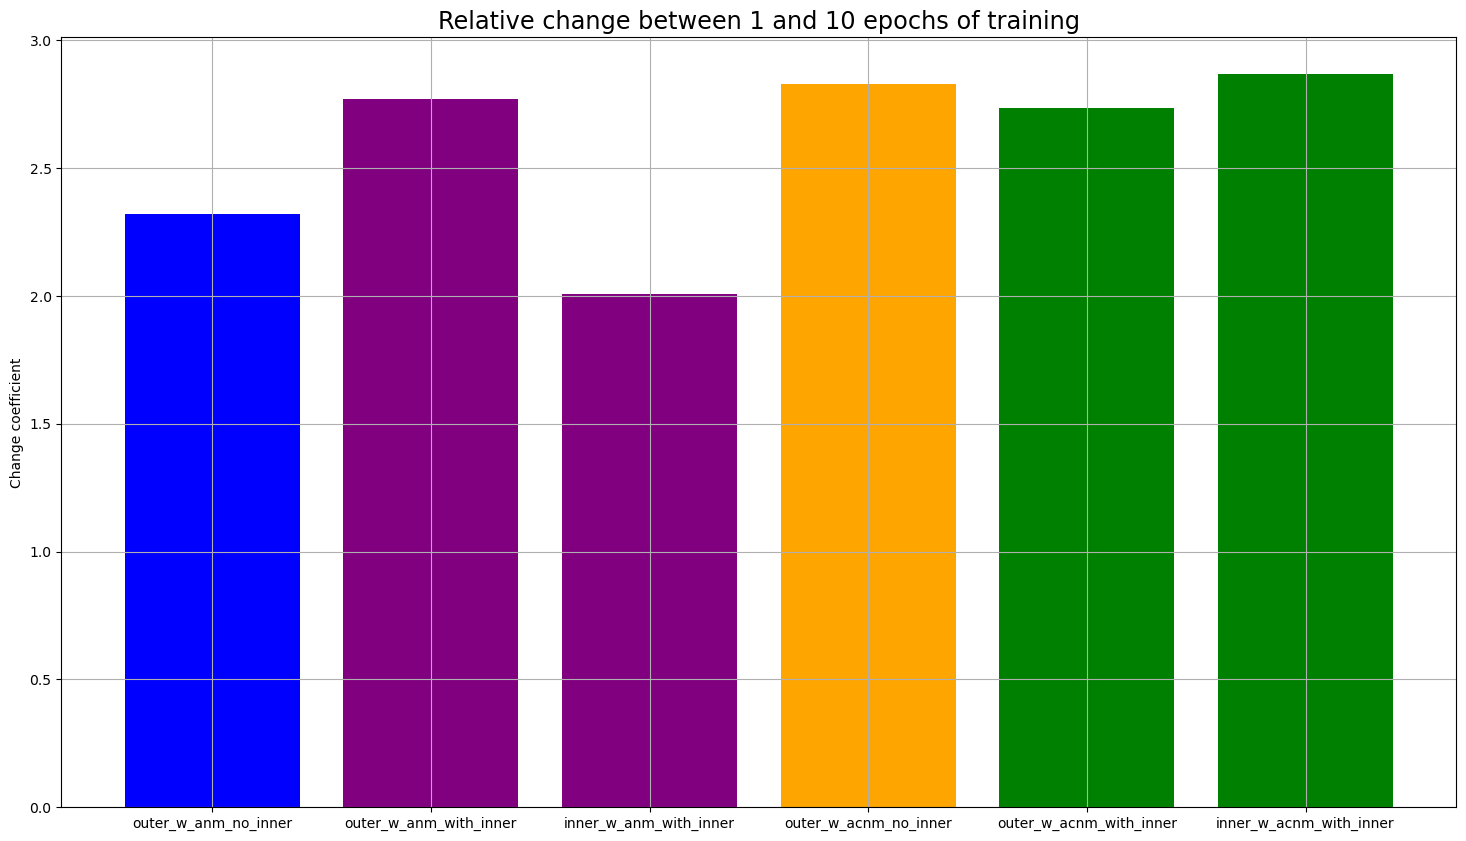

In [34]:
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot()

plt.title("Relative change between 1 and 10 epochs of training", fontsize="xx-large")

x = ['outer_w_anm_no_inner', 'outer_w_anm_with_inner', 'inner_w_anm_with_inner',
     'outer_w_acnm_no_inner', 'outer_w_acnm_with_inner', 'inner_w_acnm_with_inner']

y = [np.sum(np.abs(e10_outer_w_anm_no_inner[index] - initial_outer_w_anm_no_inner[index]))/np.sum(np.abs(e1_outer_w_anm_no_inner[index] - initial_outer_w_anm_no_inner[index])),
      np.sum(np.abs(e10_outer_w_anm_with_inner[index] - initial_outer_w_anm_with_inner[index]))/np.sum(np.abs(e1_outer_w_anm_with_inner[index] - initial_outer_w_anm_with_inner[index])),
      np.sum(np.abs(e10_inner_w_anm_with_inner[index] - initial_inner_w_anm_with_inner[index]))/np.sum(np.abs(e1_inner_w_anm_with_inner[index] - initial_inner_w_anm_with_inner[index])),
      np.sum(np.abs(e10_outer_w_acnm_no_inner[index] - initial_outer_w_acnm_no_inner[index]))/np.sum(np.abs(e1_outer_w_acnm_no_inner[index] - initial_outer_w_acnm_no_inner[index])),
      np.sum(np.abs(e10_outer_w_acnm_with_inner[index] - initial_outer_w_acnm_with_inner[index]))/np.sum(np.abs(e1_outer_w_acnm_with_inner[index] - initial_outer_w_acnm_with_inner[index])),
      np.sum(np.abs(e10_inner_w_acnm_with_inner[index] - initial_inner_w_acnm_with_inner[index]))/np.sum(np.abs(e1_inner_w_acnm_with_inner[index] - initial_inner_w_acnm_with_inner[index]))]

w = 0.8
plt.ylabel("Change coefficient")
ax.bar(x, y, width=w, color=('blue', 'purple', 'purple', 'orange', 'green', 'green'))

plt.grid()
plt.show()

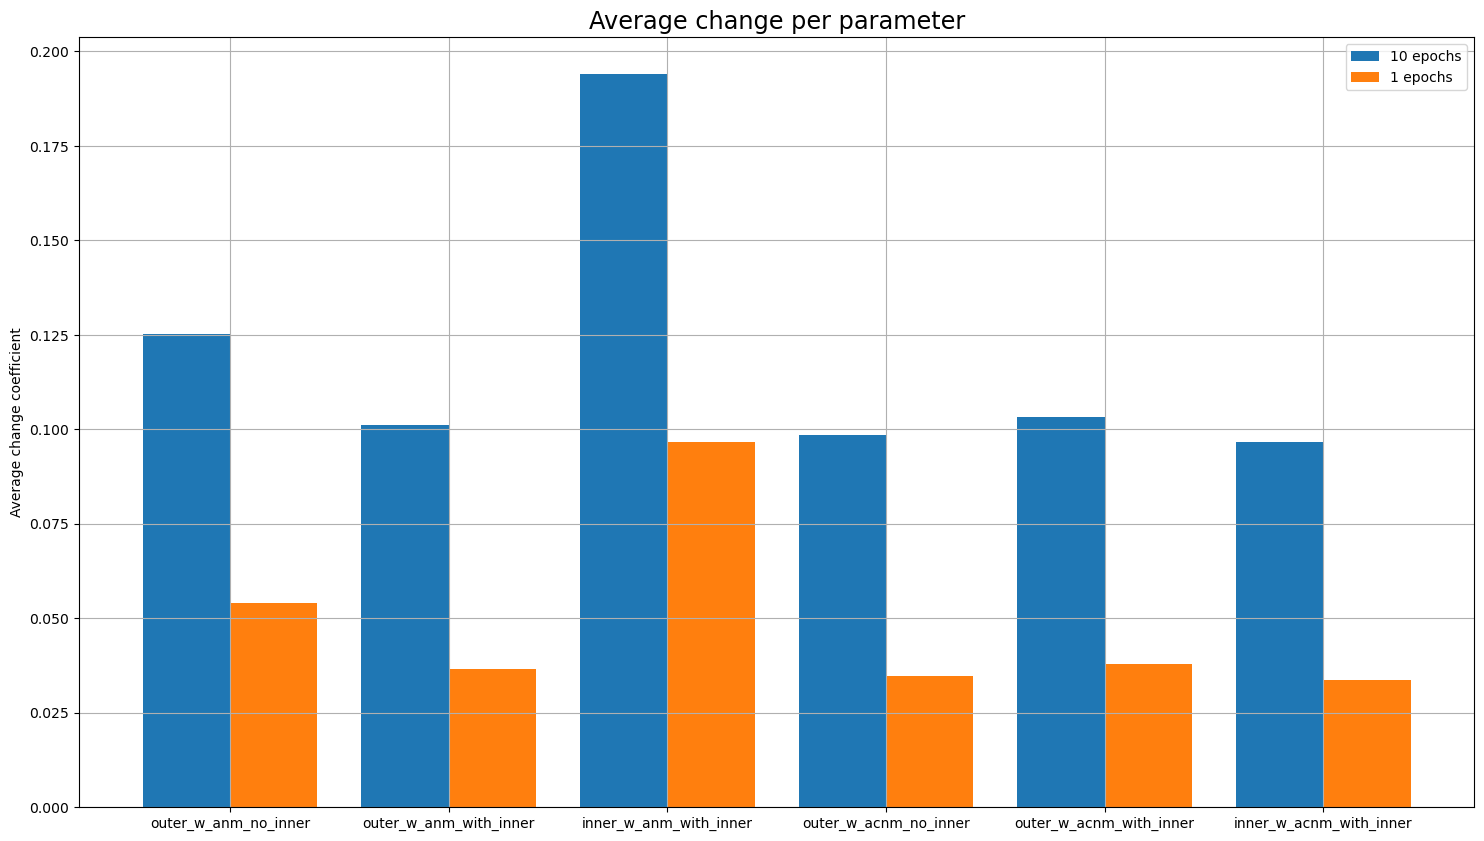

In [35]:
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot()

plt.title("Average change per parameter", fontsize="xx-large")

x = np.arange(6)
y1 = [np.average(np.abs(e10_outer_w_anm_no_inner[index] - initial_outer_w_anm_no_inner[index])),
      np.average(np.abs(e10_outer_w_anm_with_inner[index] - initial_outer_w_anm_with_inner[index])),
      np.average(np.abs(e10_inner_w_anm_with_inner[index] - initial_inner_w_anm_with_inner[index])),
      np.average(np.abs(e10_outer_w_acnm_no_inner[index] - initial_outer_w_acnm_no_inner[index])),
      np.average(np.abs(e10_outer_w_acnm_with_inner[index] - initial_outer_w_acnm_with_inner[index])),
      np.average(np.abs(e10_inner_w_acnm_with_inner[index] - initial_inner_w_acnm_with_inner[index]))]

y2 = [np.average(np.abs(e1_outer_w_anm_no_inner[index] - initial_outer_w_anm_no_inner[index])),
      np.average(np.abs(e1_outer_w_anm_with_inner[index] - initial_outer_w_anm_with_inner[index])),
      np.average(np.abs(e1_inner_w_anm_with_inner[index] - initial_inner_w_anm_with_inner[index])),
      np.average(np.abs(e1_outer_w_acnm_no_inner[index] - initial_outer_w_acnm_no_inner[index])),
      np.average(np.abs(e1_outer_w_acnm_with_inner[index] - initial_outer_w_acnm_with_inner[index])),
      np.average(np.abs(e1_inner_w_acnm_with_inner[index] - initial_inner_w_acnm_with_inner[index]))]

w = 0.4

plt.ylabel("Average change coefficient")
ax.bar(x - w/2, y1, width = w, label="10 epochs")
ax.bar(x + w/2, y2, width = w, label="1 epochs")

plt.xticks([r for r in range(len(y1))], 
        ['outer_w_anm_no_inner', 'outer_w_anm_with_inner', 'inner_w_anm_with_inner',
     'outer_w_acnm_no_inner', 'outer_w_acnm_with_inner', 'inner_w_acnm_with_inner'])

plt.legend()
plt.grid()
plt.show()